In [1]:
import os
import sys
sys.path.insert(0,'./tools/')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cmo

import cartopy.crs as ccrs

from tools.config import OPSAREA, MAPEXTENT
from maps import *

In [9]:
# Settings
figdir  = 'img/'
filename = 'SSTSnapshot'
extension = ['png']
figproperties = dict(dpi=200,bbox_inches='tight')

In [2]:
# Get the data from WHOI's S-MODE thredds
url = 'http://smode.whoi.edu:8080/thredds/dodsC/satellite/VIIRS_NRT/VIIRS_NRT_20210929T213000Z.nc'
sst = xr.open_dataset(url)

In [3]:
sst

<xarray.Dataset>
Dimensions:                  (time: 1, nj: 697, ni: 1139)
Coordinates:
  * time                     (time) datetime64[ns] 2021-09-29T21:30:01
    lat                      (nj, ni) float32 ...
    lon                      (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature  (time, nj, ni) float32 ...
    quality_level            (time, nj, ni) float32 ...
Attributes: (12/65)
    geospatial_bounds:                        POLYGON((-106.573  70.289, -110...
    geospatial_first_scanline_first_fov_lat:  36.07733
    geospatial_first_scanline_first_fov_lon:  -110.40772
    geospatial_first_scanline_last_fov_lat:   31.129335
    geospatial_first_scanline_last_fov_lon:   -143.09029
    geospatial_last_scanline_first_fov_lat:   70.288795
    ...                                       ...
    netcdf_version_id:                        4.5.0 of Jul 20 2018 12:34:15 $
    History:                                  Translated to CF-1.0 Convention...
    geospatial_lat_min:                       34.24726867675781
    geospatial_lat_max:                       40.177825927734375
    geospatial_lon_min:                       -131.56784057617188
    geospatial_lon_max:                       -119.33301544189453

# A quick-and-dirty plot

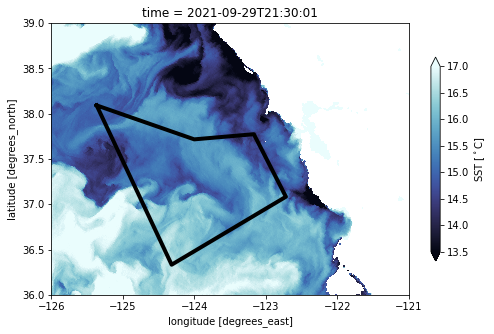

In [23]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

kwargs = dict(vmin=13.5,vmax=17,
              cmap=cmo.cm.ice,ax=ax,
              add_colorbar=False)

im = (sst.sea_surface_temperature.\
                isel(time=0)-273.15).\
                plot.pcolormesh(x='lon',
                                y='lat',
                                **kwargs
                )

ax.plot(OPSAREA['longitude'],
        OPSAREA['latitude'],
        color='k',linewidth=4
   )

ax.set_xlim(*MAPEXTENT[:2])
ax.set_ylim(*MAPEXTENT[2:])

plt.colorbar(im,label=r'SST [$^\circ$C]',
             shrink=0.75,extend='both')

## A publication-quality plot

In [22]:
projection = ccrs.PlateCarree(
                central_longitude=(MAPEXTENT[0]+MAPEXTENT[1])/2
)

map_axes = (GeoAxes,{'map_projection':projection})

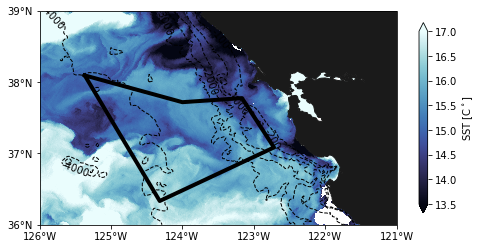

In [26]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111, projection=projection)     

ax.set_extent(MAPEXTENT)


kwargs = dict(vmin=13.5,vmax=17,
              cmap=cmo.cm.ice,ax=ax,
              add_colorbar=False,
              transform=ccrs.PlateCarree())

im = (sst.sea_surface_temperature.\
                isel(time=0)-273.15).\
                plot.pcolormesh(x='lon',
                                y='lat',
                                **kwargs
                )

# Topography
plot_topography(ax, 
                transform=ccrs.PlateCarree(),
                colors=False)

# Map properties (continent, labels, grid)
plot_map_properties(ax,
                    transform=ccrs.PlateCarree())

# # SMODE area
plot_operations_area(ax=ax,
                     transform=ccrs.PlateCarree(),
                     add_label=False,
)

fig.colorbar(im,shrink=0.5,extend='both',
             label=r'SST [C$^\circ$]')

fig.savefig(os.path.join(
                figdir,filename+'_cartopy.'+extension[0]),
            **figproperties)